<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S15A-Assignment/DenseDepthModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd gdrive/My\ Drive/DenseDepth_DataSet

/content/gdrive/My Drive/DenseDepth_DataSet


In [4]:
!ls -l

total 36
drwx------ 2 root root  4096 May 10 02:49 DenseDepth
-rw------- 1 root root 32562 May 10 02:40 denseDepthImages.zip


In [0]:

!git clone https://github.com/ialhashim/DenseDepth.git

Cloning into 'DenseDepth'...
remote: Enumerating objects: 235, done.
remote: Total 235 (delta 0), reused 0 (delta 0), pack-reused 235
Receiving objects: 100% (235/235), 11.80 MiB | 2.69 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth/nyu.h5

--2020-05-10 02:50:15--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.52.146
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.52.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DenseDepth/nyu.h5’

./DenseDepth/nyu.h5 100%[===================>] 164.89M  9.23MB/s    in 21s     

2020-05-10 02:50:37 (8.03 MB/s) - ‘./DenseDepth/nyu.h5’ saved [172897376/172897376]



In [5]:
!ls DenseDepth/

augment.py	demo.py		  examples   model.py	  README.md   utils.py
callbacks.py	demo_rgb.npy	  layers.py  nyu.h5	  Tensorflow
data.py		DenseDepth.ipynb  LICENSE    __pycache__  test.py
demo_depth.npy	evaluate.py	  loss.py    PyTorch	  train.py


In [6]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from matplotlib import pyplot as plt
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict

MODEL_PATH = 'DenseDepth/nyu.h5'

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(MODEL_PATH, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(MODEL_PATH))

Using TensorFlow backend.


Loading model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.




Model loaded (DenseDepth/nyu.h5).


In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [8]:
!ls 

DenseDepth  denseDepthImages.zip


In [9]:
!pwd

/content/gdrive/My Drive/DenseDepth_DataSet


In [11]:

from zipfile import ZipFile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import skimage
from skimage.transform import resize
from itertools import groupby
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from time import time
import gc
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
fg_bg_zip =  ZipFile('denseDepthImages.zip', 'r')

In [0]:
all_files = [info.filename for info in fg_bg_zip.infolist() if not info.is_dir()]

In [0]:
images = []
for file in all_files[:3]:
    imgdata = fg_bg_zip.read(file)
    img = Image.open(io.BytesIO(imgdata))
    img = img.resize((640, 480)) 
    x = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
    images.append(x)

In [0]:
images = np.stack(images, axis=0)

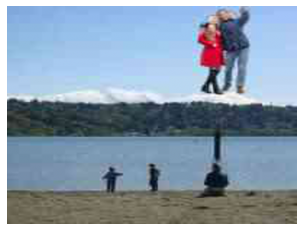

In [16]:
plt.imshow(images[0])
plt.grid('off')
plt.axis('off')
plt.show()


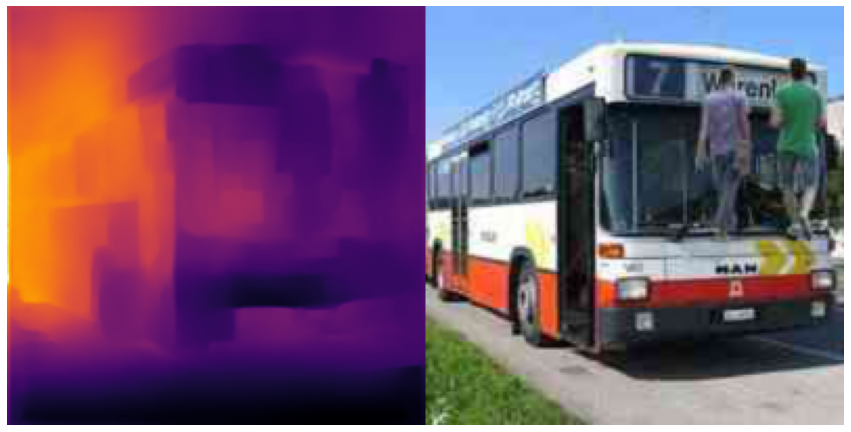

In [17]:
output = predict(model, images)
outputs, inputs = output.copy(), images.copy()
output, input = outputs[2], inputs[2]
output, input = resize(output, (200, 200)), resize(input, (200, 200))
plasma = plt.get_cmap('inferno')
rescaled = output[:,:,0]
rescaled = rescaled - np.min(rescaled)
rescaled = rescaled / np.max(rescaled)
out_img = plasma(rescaled)[:,:,:3]
img_set = np.hstack([out_img, input])
plt.figure(figsize=(15, 10))
plt.imshow(img_set)
plt.axis('off')
plt.grid('off')

In [18]:

greyDense = Image.fromarray(rescaled * 255)
greyDense = greyDense.convert('L')
byteIO = io.BytesIO()
greyDense.save(byteIO, format='PNG')
byteArr = byteIO.getvalue()
greyDense.save('test.png')
out_zip = ZipFile('zip_test.zip', mode='w', compression=zipfile.ZIP_STORED)
out_zip.write('test.png', arcname='greyDense/greyDense.png')
out_zip.close()
in_zip = ZipFile('zip_test.zip')
in_zip.infolist()

[<ZipInfo filename='greyDense/greyDense.png' filemode='-rw-------' file_size=9455>]

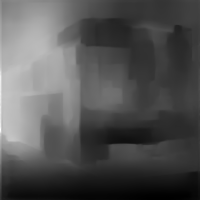

In [19]:
imgdata = in_zip.read('greyDense/greyDense.png')
img = Image.open(io.BytesIO(imgdata)).convert('L')
img

In [23]:
fg_bg_zip =  ZipFile('denseDepthImages.zip', 'r')
out_zip = ZipFile('dd_output_fg_bg.zip', mode='a', compression=zipfile.ZIP_STORED)
all_files = [info.filename for info in fg_bg_zip.infolist() if not info.is_dir()]
images = []
for file in all_files[:6]:
    imgdata = fg_bg_zip.read(file)
    img = Image.open(io.BytesIO(imgdata))
    img = img.resize((640, 480)) 
    x = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
    images.append(x)
images = np.stack(images, axis=0)

t1 = time()
output = predict(model, images)
outputs = output.copy()
t2 = time()
print(f'Prediction done took {(t2-t1):.5f} s')

# resize the outputs to `200x200` and extract channel 0
outputs = [ resize(output, (200, 200))[:, :, 0] for output in outputs]

# create a temporary directory to save the png outputs of current bg directory
Path(f'temp_b').mkdir(parents=True, exist_ok=True)

print('Saving to Zip File')
# for every output, save the output by appending mask to it
index = 0
for o, output in enumerate(tqdm(outputs)):
    
    parent_f = "dd_fg_bg" + str(index)
    f_name = "dd_fg_bg" + str(index)
    img = Image.fromarray(output * 255)
    img = img.convert('L')
    img.save(f'temp_b/temp.png')
    index = index + 1

    out_zip.write('temp_b/temp.png', f'mask_fg_bg/{parent_f}/mask_{f_name}.png')

del output, outputs, images

out_zip.close()

Prediction done took 0.55776 s
Saving to Zip File


In [24]:
print(all_files)

['densedepthImages/fg_019_bg_084_336780.jpg', 'densedepthImages/fg_079_bg_093_375170.jpg', 'densedepthImages/fg_079_bg_099_399194.jpg', 'densedepthImages/fg_079_bg_095_383171.jpg', 'densedepthImages/fg_059_bg_074_298366.jpg', 'densedepthImages/fg_059_bg_099_398394.jpg', 'densedepthImages/fg_039_bg_099_397593.jpg', 'densedepthImages/fg_019_bg_099_396793.jpg']
